<a href="https://colab.research.google.com/github/Izzy55/STOCK-MARKET-PREDICTION/blob/master/Copy_of_StockMarketPredictionNotebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
api_key = '9CU08VA5IYTPJ0CH'

# ticker for stock market prices
ticker = "AAL" 

# JSON file with all the stock market data for AAL within the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
print(url_string)
# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# If data not already saved,
# retrieve the data from the url
# And store date, low, high, volume, close, open values to a Pandas dataframe
if not os.path.exists(file_to_save):
  with urllib.request.urlopen(url_string) as url:
      data = json.loads(url.read().decode())
      # extract stock market data
      data = data['Time Series (Daily)']
      df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
      for k,v in data.items():
          date = dt.datetime.strptime(k, '%Y-%m-%d')
          data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                      float(v['4. close']),float(v['1. open'])]
          df.loc[-1,:] = data_row
          df.index = df.index + 1
  print('Data saved to : %s'%file_to_save)        
  df.to_csv(file_to_save)

# If the data is already there, load it from the CSV
else:
  print('File already exists. Loading data from CSV')
  df = pd.read_csv(file_to_save)



https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAL&outputsize=full&apikey=9CU08VA5IYTPJ0CH
Data saved to : stock_market_data-AAL.csv


In [ ]:
# Sort DataFrame by date and print first 5 rows

df = df.sort_values('Date')

df.head()

,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


In [ ]:
#Look at Shape

df.shape

(3759, 5)

In [ ]:
#General Summary

df.describe(include='all')

,Date,Low,High,Close,Open
count,3759,3759.0,3759.0,3759.0,3759.0
unique,3759,2547.0,2634.0,2606.0,2525.0
top,2008-01-28,33.0,9.1,42.3,47.4
freq,1,6.0,6.0,6.0,6.0


In [ ]:
#column summaries

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3759 entries, 0 to 3758
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3759 non-null   object
 1   Low     3759 non-null   object
 2   High    3759 non-null   object
 3   Close   3759 non-null   object
 4   Open    3759 non-null   object
dtypes: object(5)
memory usage: 176.2+ KB


Text(0, 0.5, 'Mid Price')

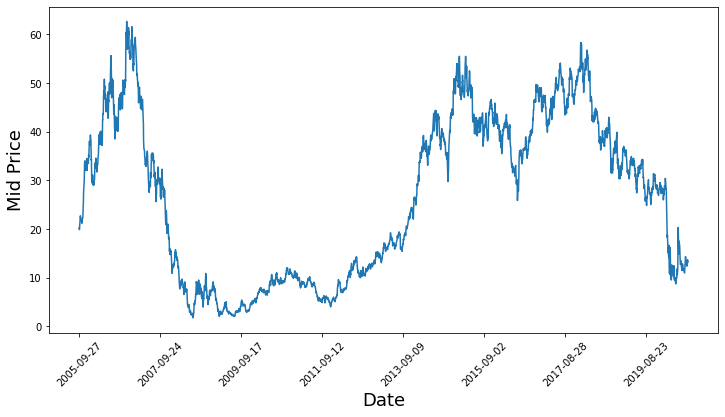

In [ ]:
#Plot Visualization

plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

Now we have to devide the data into test and train set and standardize the data for training

In [ ]:
df.count()

Date     3759
Low      3759
High     3759
Close    3759
Open     3759
dtype: int64

In [ ]:
train_test_split_i = 3230
high_prices = df['High'].to_numpy()
low_prices = df['Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [ ]:
# Split data training vs testing
train_data = mid_prices[:train_test_split_i]
test_data = mid_prices[train_test_split_i:]

In [ ]:
# Normalize data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Smoothing
smoothing_window_size = 800
for di in range(0, 3200, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:]=scaler.transform(train_data[di:di+smoothing_window_size,:])
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape data
train_data = train_data.reshape(-1)

In [ ]:
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# EMA
EMA = 0.0
gamma = 0.1
for ti in range(train_test_split_i):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [ ]:
# Long Short-Term Memory models
class DataGeneratorSeq(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices)-num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
         
    def next_batch(self):
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
         
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b]+np.random.randint(0,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
        return batch_data, batch_labels
     
    def unroll_batches(self):
        unroll_data, unroll_labels = [], []
        init_data, init_label = None, None
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [ ]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

In [ ]:
for ui, (dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\nUnrolled index %d' %ui)
    print('\tInputs: ', dat)
    print('\tOutputs: ', lbl)


Unrolled index 0
	Inputs:  [0.03039658 0.11386113 0.9086873  0.22098817 0.5297762 ]
	Outputs:  [0.08195353 0.10582841 0.9019714  0.21745555 0.5297762 ]

Unrolled index 1
	Inputs:  [0.05712127 0.11038207 0.9052055  0.21936335 0.5306424 ]
	Outputs:  [0.12644066 0.10658476 0.89662695 0.2150911  0.5212461 ]

Unrolled index 2
	Inputs:  [0.08195353 0.10770252 0.9019714  0.21857075 0.5305746 ]
	Outputs:  [0.10475415 0.10770252 0.8982064  0.2150911  0.50966275]

Unrolled index 3
	Inputs:  [0.10475415 0.10637474 0.8982064  0.21745555 0.5278946 ]
	Outputs:  [0.18349193 0.10637474 0.8982064  0.21437539 0.5149388 ]

Unrolled index 4
	Inputs:  [0.12644066 0.10582841 0.89662695 0.21628703 0.5212461 ]
	Outputs:  [0.1470177  0.10897837 0.89463466 0.21628703 0.504144  ]


In [ ]:
D = 1 # Dimensionality of the data
num_unrollings = 50 # Number of time steps into the future
batch_size = 500 # Number of samples in a batch
num_nodes = [200, 200, 150] # Number of hidden nodes in each layer of the deep LSTM stack
n_layers = len(num_nodes) # Number of layers
dropout = 0.2 # Dropout amount

In [ ]:
# Reinitialize
tf.reset_default_graph()

In [ ]:
# Inputs
train_inputs = [tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui) for ui in range(num_unrollings)]
train_outputs = [tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui) for ui in range(num_unrollings)]

In [ ]:
# Set up the LSTM and Regression layers
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                           state_is_tuple=True,
                           initializer=tf.contrib.layers.xavier_initializer())
    for li in range(n_layers)]
 
drop_lstm_cells = [
    tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob=1.0,
                                 output_keep_prob=1.0-dropout,
                                 state_keep_prob=1.0-dropout)
    for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [ ]:
# LSTM layers
w = tf.get_variable('w',shape=[num_nodes[-1],1],
                   initializer=tf.contrib.layers.xavier_initializer())
# Linear regression layer
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))
 
# Cell state and hidden state
c = [tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False) for li in range(n_layers)]
h = [tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False) for li in range(n_layers)]
initial_state = [tf.contrib.rnn.LSTMStateTuple(c[li], h[li]) for li in range(n_layers)]

In [ ]:
# Formatting
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs], axis=0)
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major=True, dtype=tf.float32)
all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings, num_nodes[-1]])
 
all_outputs = tf.nn.xw_plus_b(all_lstm_outputs, w, b)
split_outputs = tf.split(all_outputs,num_unrollings, axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Training loss
# Mean Squared Error (MSE)
loss = 0.0
with tf.control_dependencies([tf.assign(c[li],state[li][0]) for li in range(n_layers)]+
                            [tf.assign(h[li],state[li][1]) for li in range(n_layers)]):
    loss += sum([tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2) for ui in range(num_unrollings)])
 
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step, global_step+1)
tf_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None, dtype=tf.float32)
 
learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate,global_step,
                               decay_steps=1, decay_rate=0.5,
                              staircase=True),
    tf_min_learning_rate)

In [ ]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients,v))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Defining prediction related TF calculations
sample_inputs = tf.placeholder(tf.float32, shape=[1,D])
sample_c = [tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False) for li in range(n_layers)]
sample_h = [tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False) for li in range(n_layers)]
initial_sample_state = [tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]) for li in range(n_layers)]
 
reset_sample_states = tf.group(*[[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]+
                               [tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]])
sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                                initial_state=tuple(initial_sample_state),
                                                time_major=True,
                                                dtype=tf.float32)
with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                            [tf.assign(sample_h[li], sample_state[li][1]) for li in range(n_layers)]):
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]),w,b)

In [ ]:
# Initialise before Running
epochs = 30
valid_summary = 1
n_predict_once = 50
train_seq_length = train_data.size
train_mse_ot = []
test_mse_ot = []
predictions_over_time = []
 
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2
average_loss = 0
 
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)
x_axis_seq = []
test_points_seq = np.arange(train_test_split_i,train_test_split_i+100,n_predict_once).tolist()

In [ ]:
for ep in range(epochs):
    # =================== Training =======================
    for step in range(train_seq_length//batch_size):
        u_data, u_labels = data_gen.unroll_batches()
        feed_dict = {}
        for ui, (dat,lbl) in enumerate(zip(u_data,u_labels)):
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
    # =================== Validation =======================
    if (ep+1) % valid_summary == 0:
        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' %(ep+1, average_loss))
        train_mse_ot.append(average_loss)
        average_loss = 0
        predictions_seq, mse_test_loss_seq = [], []
    # =================== Update and make prediction =======================
    for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        if (ep+1)-valid_summary==0:
            x_axis=[]
        for tr_i in range(w_i-num_unrollings+1, w_i-1):
            current_price = all_mid_data[tr_i]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
            _ = session.run(sample_prediction, feed_dict=feed_dict)
         
        feed_dict = {}
        current_price = all_mid_data[w_i-1]
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        for pred_i in range(n_predict_once):
            pred = session.run(sample_prediction, feed_dict=feed_dict)
            our_predictions.append(np.asscalar(pred))
            feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)
            if (ep+1)-valid_summary==0:
                x_axis.append(w_i+pred_i)
            mse_test_loss += 0.5 *(pred-all_mid_data[w_i+pred_i])**2
        session.run(reset_sample_states)
        predictions_seq.append(np.array(our_predictions))
        mse_test_loss/=n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        if (ep+1)-valid_summary==0:
            x_axis_seq.append(x_axis)
    current_test_mse = np.mean(mse_test_loss_seq)
     
    # learning rate decay logic
    if len(test_mse_ot)>0 and current_test_mse>min(test_mse_ot):
        loss_nondecrease_count += 1
    else:
        loss_nondecrease_count = 0
     
    if loss_nondecrease_count > loss_nondecrease_threshold:
        session.run(inc_gstep)
        loss_nondecrease_count = 0
        # Decreasing learning rate by 0.5
    test_mse_ot.append(current_test_mse)
    print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
    predictions_over_time.append(predictions_seq)
    print('\tFinished Predictions') 

Average loss at step 1: 3.560909


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.10107
	Finished Predictions
Average loss at step 2: 1.032883
	Test MSE: 0.19390
	Finished Predictions
Average loss at step 3: 0.686213
	Test MSE: 0.30414
	Finished Predictions
Average loss at step 4: 0.418531
	Test MSE: 0.15024
	Finished Predictions
Average loss at step 5: 0.279075
	Test MSE: 0.16358
	Finished Predictions
Average loss at step 6: 0.221030
	Test MSE: 0.19671
	Finished Predictions
Average loss at step 7: 0.214286
	Test MSE: 0.17298
	Finished Predictions
Average loss at step 8: 0.203611
	Test MSE: 0.16826
	Finished Predictions
Average loss at step 9: 0.187727
	Test MSE: 0.17528
	Finished Predictions
Average loss at step 10: 0.180531
	Test MSE: 0.18067
	Finished Predictions
Average loss at step 11: 0.177550
	Test MSE: 0.17785
	Finished Predictions
Average loss at step 12: 0.172277
	Test MSE: 0.17313
	Finished Predictions
Average loss at step 13: 0.171574
	Test MSE: 0.17114
	Finished Predictions
Average loss at step 14: 0.167168
	Test MSE: 0.17256
	Finished Pred

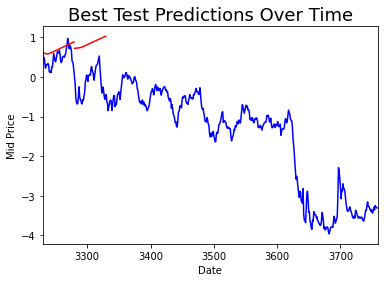

In [ ]:
# Plot
 
best_prediction_epoch = 2
 
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
plt.title('Best Test Predictions Over Time', fontsize=18)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Mid Price',fontsize=10)
plt.xlim(train_test_split_i,len(df))
plt.show()

## Decision Tree Regression Model and Linear Regression Model

In [ ]:
# Import necessary models from sklearn

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# re-look at the initial data

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3759 entries, 0 to 3758
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3759 non-null   object
 1   Low     3759 non-null   object
 2   High    3759 non-null   object
 3   Close   3759 non-null   object
 4   Open    3759 non-null   object
dtypes: object(5)
memory usage: 176.2+ KB
None
         Date    Low   High  Close   Open
0  2005-09-27   19.1   21.4   19.3  21.05
1  2005-09-28   19.2  20.53   20.5   19.3
2  2005-09-29   20.1  20.58  20.21   20.4
3  2005-09-30  20.18  21.05  21.01  20.26
4  2005-10-03   20.9  21.75   21.5   20.9


In [ ]:
# number of rows = number of trading days

print(df.shape)

(3759, 5)


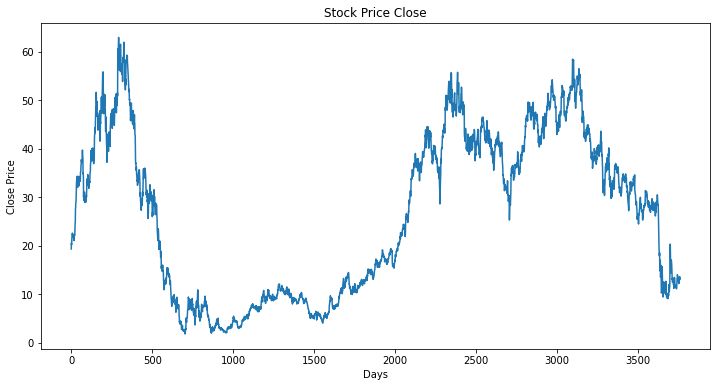

In [ ]:
# Prediction to be made on close price data
# Visualisation of close price

plt.figure(figsize=(12,6))
plt.title('Stock Price Close')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.plot(df['Close'])
plt.show()

In [ ]:
# Create close price only dataframe

close_df = df[['Close']]
print(close_df.head())

   Close
0   19.3
1   20.5
2  20.21
3  21.01
4   21.5


In [ ]:
# Define Variables

days_to_future = 30    # Days into future model will predict into

# Add target column to close_df with data for price shifted 'days_to_future' ahead
close_df['Prediction'] = df[['Close']].shift(-days_to_future)
print(close_df.head())

   Close Prediction
0   19.3      29.43
1   20.5       31.3
2  20.21       32.8
3  21.01      33.35
4   21.5      33.75


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Verify predictions for end of dataframe are NaN
print(close_df.tail())

       Close Prediction
3754  12.785        NaN
3755   13.28        NaN
3756   13.59        NaN
3757   13.05        NaN
3758    13.1        NaN


In [ ]:
# Create feature dataset 'X'
# Leave off last 'days_to_future' rows

X = np.array(close_df.drop(['Prediction'], 1))[:-days_to_future]
print(X[:10])
print(X.shape)

[[19.3]
 [20.5]
 [20.21]
 [21.01]
 [21.5]
 [22.16]
 [22.2]
 [22.58]
 [22.15]
 [22.21]]
(3729, 1)


In [ ]:
# Create target dataset 'y'
# Leave off last 'days_to_future' rows

y = np.array(close_df.drop(['Close'], 1))[:-days_to_future]
print(y[:10])
print(y.shape)

[[29.43]
 [31.3]
 [32.8]
 [33.35]
 [33.75]
 [33.88]
 [33.6]
 [34.32]
 [33.05]
 [31.99]]
(3729, 1)


In [ ]:
# Split data into 20% test and 80% train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# Create Decision Tree Regressor model

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
print(tree_mse)

34.04857085732276


In [ ]:
# Create Linear Regression model

linear = LinearRegression()
linear.fit(X_train, y_train)
linear_pred = linear.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_pred)
print(linear_mse)

20.66502699460449


In [ ]:
future_days = close_df.drop(['Prediction'], 1)[:-days_to_future]
future_days = future_days.tail(days_to_future)
future_days = np.array(future_days)
print(future_days)

[[18.55]
 [17.02]
 [14.38]
 [16.74]
 [16.7]
 [17.03]
 [16.98]
 [16.49]
 [16.0]
 [14.92]
 [14.0]
 [13.04]
 [13.17]
 [12.38]
 [13.32]
 [13.07]
 [12.81]
 [12.5]
 [12.8]
 [11.91]
 [11.99]
 [11.18]
 [11.94]
 [11.63]
 [11.57]
 [13.44]
 [12.45]
 [11.91]
 [11.47]
 [11.47]]


In [ ]:
# Predict with Decision Tree Model
tree_predict = tree_model.predict(future_days)
print(tree_predict)

[13.95       11.77       11.39       11.39       11.77       11.4
 14.12       11.12       11.08       13.495      16.67       13.04
 11.92       14.24       13.885      13.54       13.3        12.96333333
 12.62       13.095      10.415      12.55666667 12.16       13.44
 12.24       13.6725     13.28       13.095      11.6875     11.6875    ]


In [ ]:
# Preduct with Linear Regression Model

linear_predict = linear.predict(future_days)
print(linear_predict)

[[18.73637189]
 [17.26376757]
 [14.72280326]
 [16.99427136]
 [16.9557719 ]
 [17.27339244]
 [17.22526811]
 [16.75364974]
 [16.28203136]
 [15.24254596]
 [14.35705839]
 [13.43307137]
 [13.55819461]
 [12.79783029]
 [13.70256759]
 [13.46194596]
 [13.21169948]
 [12.91332867]
 [13.20207461]
 [12.34546164]
 [12.42246056]
 [11.64284651]
 [12.37433624]
 [12.07596543]
 [12.01821624]
 [13.81806596]
 [12.86520435]
 [12.34546164]
 [11.92196759]
 [11.92196759]]


In [ ]:
# Future Prediction MSE, linear and decision tree

future_tree_mse = mean_squared_error(future_days, tree_predict)
future_linear_mse = mean_squared_error(future_days, linear_predict)

print('30 Day Tree Future Prediction MSE: ', future_tree_mse)
print('30 Day Linear Future Prediction MSE: ', future_linear_mse)

30 Day Tree Future Prediction MSE:  7.683799421296295
30 Day Linear Future Prediction MSE:  0.1402720233447883


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


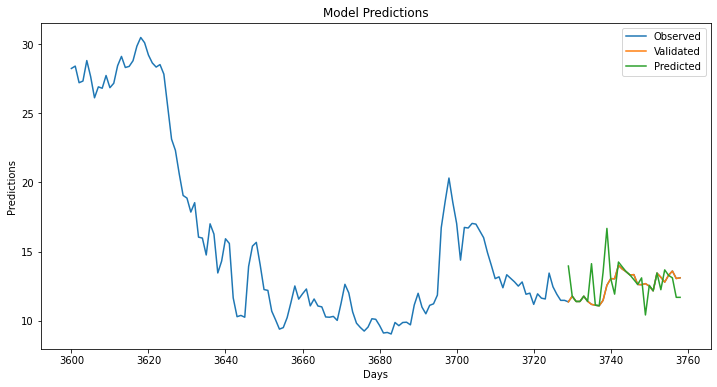

In [ ]:
# Visualization of results

predictions = tree_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = predictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[3600:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


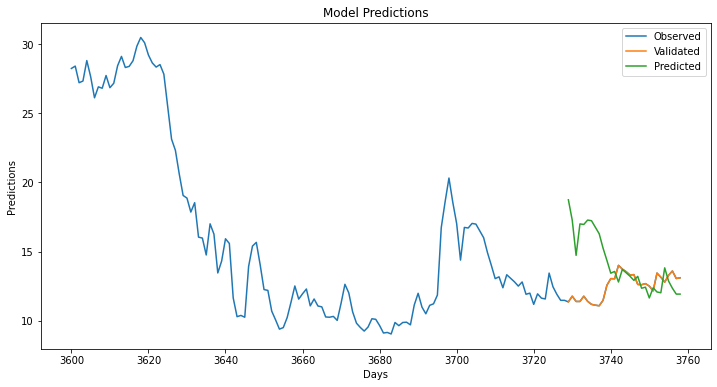

In [ ]:
# Visualize Linear Model Results

lpredictions = linear_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = lpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[3600:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

## XG Boost Model

In [ ]:
import xgboost as xgb

# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)


# Create the parameter dictionary: params
params = {"objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
xgb_mse = mean_squared_error(X_test,preds)
print("MSE: %f" % (xgb_mse))

MSE: 33.327067


In [ ]:
# Cross Validation with XGBoost

# Create the DMatrix: xgb_dmatrix
xgb_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=xgb_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        22.005149        0.104944       22.009114       0.325622
1        15.732067        0.072543       15.741010       0.246265
2        11.443512        0.049982       11.472296       0.179282
3         8.577700        0.034461        8.628646       0.145326
4         6.729688        0.023624        6.808218       0.113456
4    6.808218
Name: test-rmse-mean, dtype: float64


In [ ]:
# Hyperparameter tuning using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'colsample_bytree': np.arange(0.2, 0.7, 0.1),
    'learning_rate': np.arange(0.04, 1, 0.02),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50)

}

# Instantiate the regressor: gbm
rs_gbm = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions=gbm_param_grid, estimator=rs_gbm, scoring="neg_mean_squared_error", verbose=1, n_iter=5, cv=4)


# Fit randomized_mse to the data
randomized_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.31999999999999995, 'colsample_bytree': 0.2}
Lowest RMSE found:  5.209618529924693


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.3s finished


In [ ]:
# Create the parameter dictionary: params
best_params = {"objective":"reg:squarederror", 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.31999999999999995, 'colsample_bytree': 0.2 }

# Train the model: xg_reg
best_xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
best_preds = best_xg_reg.predict(DM_test)

# Compute and print the RMSE
best_xgb_mse = mean_squared_error(X_test,best_preds)
print("RMSE: %f" % (best_xgb_mse))

MSE: 33.245991


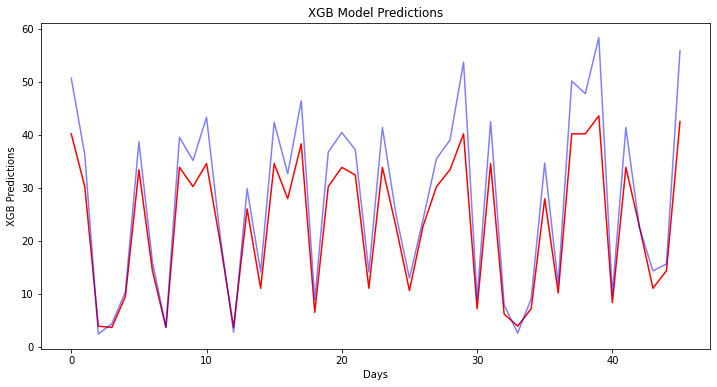

In [ ]:
# Plot Best XGB Prediction for the final 43 days
plt.figure(figsize=(12,6))
plt.title('XGB Model Predictions')
plt.xlabel('Days')
plt.ylabel('XGB Predictions')
plt.plot(best_preds[700:], c='red')
plt.plot(X_test[700:], c='blue', alpha = 0.5)
plt.show()

## One step ahead prediction using Standard Averaging technique

In [ ]:
# One step ahead prediction using Standard Averaging technique

# Define initial values and create empty arrays

window_size = 50
N = train_data.size


std_avg_predictions = []
std_avg_date = []
std_mse_errors = []

# Generate Predictions and append predictions, dates, and errors to correct arrays

for idx in range(window_size, N):

  if idx >= N:
    date = dt.datetime.strptime(k, '%Y-%m-%d').date + dt.timedelta(days=1)
  else:
    date = df.loc[idx, 'Date']

  std_avg_predictions.append(np.mean(train_data[idx-window_size:idx]))
  std_mse_errors.append((std_avg_predictions[-1]-train_data[idx])**2)
  std_avg_date.append(date)  


# Print resulting MSE for Standard Averaging
print('Standard Average MSE error: %.5f'%(0.5*np.mean(std_mse_errors)))

Standard Average MSE error: 0.00410


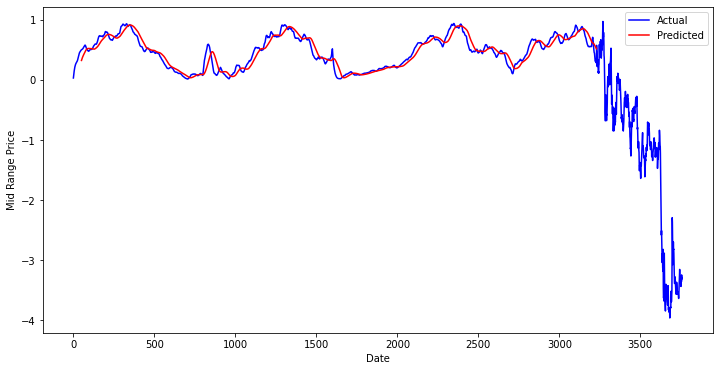

In [ ]:
# Visualize Standard Average Preduction and Actual Value on overlayed plot

plt.figure(figsize=(12,6))
plt.plot(range(df.shape[0]), all_mid_data, color='blue', label='Actual')
plt.plot(range(window_size,N), std_avg_predictions, color = 'red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Mid Range Price')
plt.legend()
plt.show()

## One step ahead prediction using the Exponential Moving Average

In [ ]:
# One step ahead prediction using the Exponential Moving Average

# Define initial values and create empty arrays 

window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_dates = []
run_mse_errors = []

running_mean = 0.0     # exponential moving average
decay = 0.5            # gamma

run_avg_predictions.append(running_mean)

# Generate Predictions and append predictions, dates, and errors to correct arrays

for ema_idx in range(1,N):
  running_mean = running_mean*decay + (1-decay)*train_data[ema_idx-1]
  run_avg_predictions.append(running_mean)
  run_mse_errors.append((run_avg_predictions[-1]-train_data[ema_idx])**2)
  run_avg_dates.append(date)


# Print resulting MSE for Standard Averaging
print('Standard Average MSE error: %.5f'%(0.5*np.mean(run_mse_errors)))  

Standard Average MSE error: 0.00007


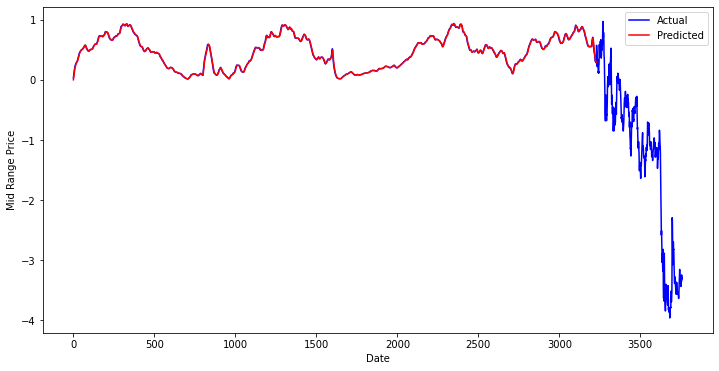

In [ ]:
# Visualize Exponential Moving Average Preduction and Actual Value on overlayed plot

plt.figure(figsize=(12,6))
plt.plot(range(df.shape[0]), all_mid_data, color='blue', label='Actual')
plt.plot(range(0,N), run_avg_predictions, color = 'red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Mid Range Price')
plt.legend()
plt.show()

## Part Two:
## Prediction Accuracy Improvement with Hyperparameter Tuning of Simple Models

In [ ]:
# Ridge Regression

from sklearn import linear_model
ridge = linear_model.Ridge(alpha=.5)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(ridge_mse)


20.66503109591042


In [ ]:
# Cross Validated RidgeCV

ridge_cv = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10)
ridge_cv.fit(X_train, y_train)
ridge_cv_pred = ridge_cv.predict(X_test)
ridge_cv_mse = mean_squared_error(y_test, ridge_cv_pred)
print(ridge_cv_mse)
print(ridge_cv.alpha_)


20.665850921818485
100.0


In [ ]:
# Future Predict with Ridge Model
ridge_predict = ridge.predict(future_days)
print(ridge_predict)

[[18.73637668]
 [17.26377325]
 [14.72281047]
 [16.9942772 ]
 [16.95577776]
 [17.27339811]
 [17.22527382]
 [16.75365572]
 [16.28203763]
 [15.24255286]
 [14.35706583]
 [13.43307936]
 [13.55820253]
 [12.79783866]
 [13.70257541]
 [13.46195394]
 [13.2117076 ]
 [12.91333697]
 [13.20208274]
 [12.34547029]
 [12.42246916]
 [11.64285558]
 [12.37434487]
 [12.07597424]
 [12.01822508]
 [13.81807372]
 [12.86521268]
 [12.34547029]
 [11.92197649]
 [11.92197649]]


In [ ]:
# Future Predict with Ridge CV Model
ridge_cv_predict = ridge_cv.predict(future_days)
print(ridge_cv_predict)

[[18.7373304 ]
 [17.26490359]
 [14.72424556]
 [16.99543986]
 [16.95694504]
 [17.27452729]
 [17.22640877]
 [16.75484724]
 [16.28328571]
 [15.24392561]
 [14.35854478]
 [13.43466913]
 [13.55977729]
 [12.79950462]
 [13.70413286]
 [13.46354025]
 [13.21332393]
 [12.91498908]
 [13.20370022]
 [12.34719051]
 [12.42418014]
 [11.64466007]
 [12.37606162]
 [12.07772677]
 [12.01998455]
 [13.81961732]
 [12.86687056]
 [12.34719051]
 [11.9237475 ]
 [11.9237475 ]]


In [ ]:
# Future Prediction MSE, Ridge and Ridge CV

future_ridge_mse = mean_squared_error(future_days, ridge_predict)
future_ridgecv_mse = mean_squared_error(future_days, ridge_cv_predict)

print('30 Day Ridge Regression Prediction MSE: ', future_ridge_mse)
print('30 Day Cross Validated Ridge Regression Prediction MSE: ', future_ridgecv_mse)

30 Day Ridge Regression Prediction MSE:  0.14027776076103646
30 Day Cross Validated Ridge Regression Prediction MSE:  0.14142170990090078


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


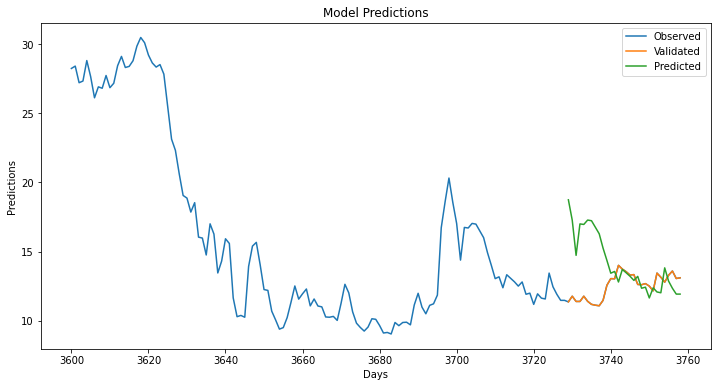

In [ ]:
# Visualize Ridge Model Results

rpredictions = ridge_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = rpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[3600:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


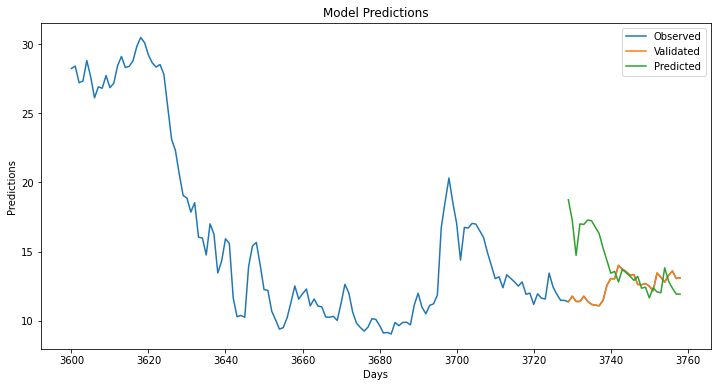

In [ ]:
# Visualize Cross Validated Ridge Model Results

rcvpredictions = ridge_cv_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = rcvpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[3600:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

In [ ]:
# Lasso

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
clf_mse = mean_squared_error(y_test, clf_pred)
print(clf_mse)

20.667605492972427


In [ ]:
# Future Predict with Lasso Model

clf_predict = clf.predict(future_days)
print(clf_predict)

[18.73934293 17.26728882 14.72727387 16.99789329 16.95940822 17.27691008
 17.22880374 16.75736157 16.2859194  15.24682238 14.36166566 13.43802386
 13.56310035 12.80302012 13.70741938 13.46688766 13.21673467 12.91847534
 13.20711341 12.35082049 12.42779064 11.64846787 12.37968429 12.08142496
 12.02369735 13.82287461 12.870369   12.35082049 11.92748466 11.92748466]


In [ ]:
# Future Prediction MSE for Lasso

future_clf_mse = mean_squared_error(future_days, clf_predict)

print('30 Day Lasso Future Prediction MSE: ', future_clf_mse)


30 Day Lasso Future Prediction MSE:  0.14385094702414003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


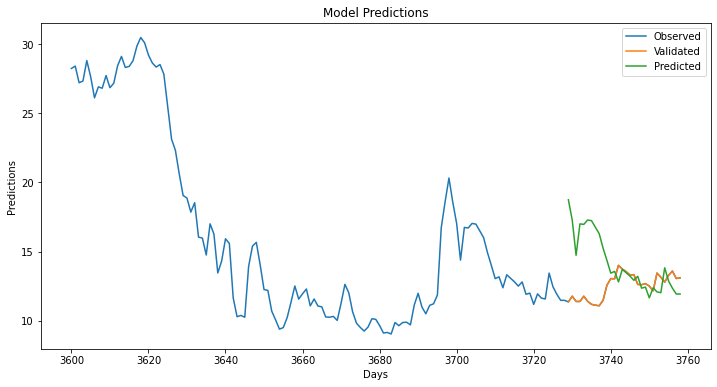

In [ ]:
# Visualize Lasso Model Results

clfpredictions = clf_predict

validation = close_df[X.shape[0]:]
validation['Predictions'] = clfpredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[3600:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

In [ ]:
# Decision Tree Regression with Randomized Hyperparameter Search

# Create the parameter grid
param_grid = {'max_depth': list(range(2,10)), 
              'max_features': ['auto' , 'sqrt'],
              'criterion' : ['mse', 'mae'],
              'splitter':['best', 'random'],
              'min_samples_leaf': list(range(5,20))
              } 

# Create a random search object
tree_rs = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(),
    param_distributions = param_grid, n_iter = 10,
    scoring='neg_mean_squared_error', cv = 5, refit=True, return_train_score =True, verbose=1 )

# Fit to the training data
tree_rs.fit(X_train, y_train)

# Print the values used for both hyperparameters
print(tree_rs.cv_results_['param_max_depth'])
print(tree_rs.cv_results_['param_max_features'])
print(tree_rs.cv_results_['param_criterion'])
print(tree_rs.cv_results_['param_splitter'])
print(tree_rs.cv_results_['param_min_samples_leaf'])

# Print the best parameters and lowest RMSE
print("Best parameters found: ", tree_rs.best_params_)
print("Lowest RMSE found: ", np.abs(tree_rs.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2 6 9 5 6 5 5 7 3 7]
['sqrt' 'sqrt' 'auto' 'auto' 'sqrt' 'auto' 'sqrt' 'sqrt' 'auto' 'sqrt']
['mae' 'mae' 'mse' 'mse' 'mse' 'mae' 'mse' 'mse' 'mae' 'mae']
['random' 'random' 'random' 'random' 'best' 'random' 'random' 'random'
 'best' 'random']
[5 13 12 17 5 15 10 8 17 7]
Best parameters found:  {'splitter': 'best', 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'mse'}
Lowest RMSE found:  20.48575847977993


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


In [ ]:
#Create new Decision Tree model using best parameters

# Create the parameter dictionary: params
best_rs_params = {'splitter':'best', 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'mse'}

# Train the model: xg_reg
best_tree_rs = DecisionTreeRegressor(splitter='best', min_samples_leaf=10, max_features='auto', max_depth=5, criterion='mse')
best_tree_rs.fit(X_train, y_train)

# Predict the labels of the test set: preds
tree_rs_preds = best_tree_rs.predict(X_test)

# Compute and print the MSE
best_treers_mse = mean_squared_error(X_test,tree_rs_preds)
print("MSE: %f" % (best_treers_mse))

MSE: 2.914654


In [ ]:
# Future Prediction with Best Decision Tree Model

future_tree_rs = best_tree_rs.predict(future_days)
print(future_tree_rs)

[16.92366667 16.92366667 12.99761745 16.92366667 16.92366667 16.92366667
 16.92366667 16.92366667 16.92366667 12.99761745 12.99761745 12.99761745
 12.99761745 12.99761745 12.99761745 12.99761745 12.99761745 12.99761745
 12.99761745 11.73583333 11.73583333 11.73583333 11.73583333 11.73583333
 11.73583333 12.99761745 12.99761745 11.73583333 11.73583333 11.73583333]


In [ ]:
# Future Prediction MSE for Best Decision Tree Model

future_treers_mse = mean_squared_error(future_days, future_tree_rs)

print('30 Day Best Tree Future Prediction MSE: ', future_treers_mse)

30 Day Best Tree Future Prediction MSE:  0.4133516821396528


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


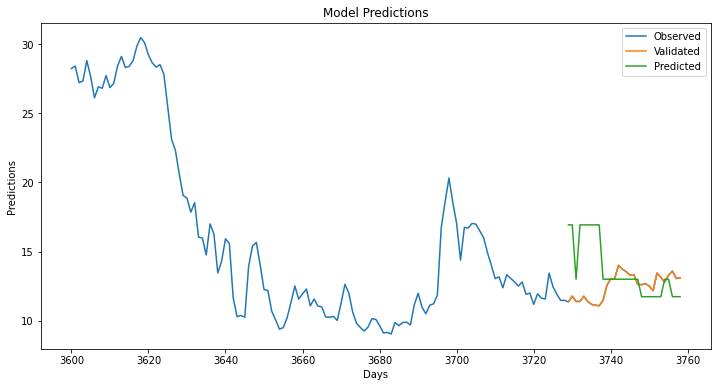

In [ ]:
# Visualize Best Tree Model Results

treerspredictions = future_tree_rs

validation = close_df[X.shape[0]:]
validation['Predictions'] = treerspredictions

plt.figure(figsize=(12,6))
plt.title('Model Predictions')
plt.xlabel('Days')
plt.ylabel('Predictions')
plt.plot(close_df['Close'].iloc[3600:])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Observed', 'Validated', 'Predicted'])
plt.show()

Referrences:

https://www.programmersought.com/article/5487636739/

https://wingkiwong.wordpress.com/2019/01/13/long-short-term-memory-in-time-series-data/

https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

https://analyticsindiamag.com/hands-on-guide-to-lstm-recurrent-neural-network-for-stock-market-prediction/

https://blog.usejournal.com/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68

https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

